In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy import signal

def get_gaussian_kernel(dim=5, sigma=1):
    get_gaussian_kernel1d = signal.gaussian(dim, std=sigma).reshape(dim, 1)
    return np.outer(get_gaussian_kernel1d, get_gaussian_kernel1d)

**Shi Thomasi Detector:**

This detector also calculates a score for each pixel corresponding to given image, and defines a pixel to be a corner, if it's score is greater than a particular threshold. It considers a fixed size window around every pixel, and calculates the eigen values of the intensity matrix corresponding to this window, and assigns the smaller eigen value as the score to each pixel (which indicates that the direction of least spread is also significant - indicating that current pixel is a corner). In below implementation, the threshold is defined based on the score values, i.e, the last 2% of the pixels whose scores are sorted in increasing order.

In [3]:
# Detects corners of a given image based on a threshold score (scores which lie in highest 2% by default)
def shi_thomasi_detector(color_image, window_size, threshold_factor=0.998):
    image = cv.cvtColor(color_image, cv.COLOR_BGR2GRAY).astype(float) / 255
    h, w = image.shape
    d = window_size // 2
    # Intensity gradients - partial derivatives along X and y axes
    Ix, Iy = np.gradient(image)
    Ix_Ix = Ix ** 2
    Iy_Iy = Iy ** 2
    Ix_Iy = Ix * Iy
    all_pixels_and_scores = []
    for i in range(d, h - d):
        for j in range(d, w - d):
            sum_xx = Ix_Ix[i - d: i + d + 1, j - d: j + d + 1].sum()
            sum_yy = Iy_Iy[i - d: i + d + 1, j - d: j + d + 1].sum()
            sum_xy = Ix_Iy[i - d: i + d + 1, j - d: j + d + 1].sum()
            # The A matrix for a fixed window around the pixel
            eigen_values, eigen_vectors = np.linalg.eig([[sum_xx, sum_xy], [sum_xy, sum_yy]])
            R = min(eigen_values)
            # Considering minimum variation (small eigen value) as score of the pixel
            all_pixels_and_scores.append(tuple([R, i, j]))
    all_pixels_and_scores = sorted(all_pixels_and_scores)
    # Considering pixels with high scores as corners
    corners = all_pixels_and_scores[int(threshold_factor * len(all_pixels_and_scores)):]
    return corners

**Lucas Kanade Optical Flow**

After converting the image to grayscale and mapping pixel intensities to a value between 0 and 1, gradients along X and Y axes are computed. These are used to compute the necessary intensity matrices which are components of the matrix formulation of Lucas Kanade equation. A window around the required pixel is considered, and the above intensity matrix terms are computed for each pixel in the window and summed up, to compute motion vector for the central pixel, by solving the equation obtained via brightness constancy and spatial coherence assumption. Based on parameters passed to the function, the local structure-tensor is used to validate if a pixel's optical flow should be computed; by defining a threshold and considering those pixels whose tensor's smallest eigen value is greated than this threshold (to obtain reliable results). 

In [4]:
def LukasKanadeForwardAdditive(Img1, Img2, windowSize, T=0.01, is_weighted=False):
    image_1, image_2 = Img1, Img2
    dw, dh = windowSize[0] // 2, windowSize[1] // 2
    h, w = image_1.shape # Assumed that both images have same shapes
    # Intensity gradients - partial derivatives along X and y axes
    Ix, Iy = np.gradient(image_1)
    Ix_Ix, Ix_Iy, Iy_Iy = Ix ** 2, Ix * Iy, Iy ** 2
    # Intensity derivative with respect to time: Difference in intensities of 2 frames
    It = image_2 - image_1
    Ix_It, Iy_It =  Ix * It, Iy * It
    u, v, motion_vectors = np.zeros((h, w)), np.zeros((h, w)), {}
    weights = np.ones((windowSize[1], windowSize[0]))
    if is_weighted:
        # Assumed that a square kernel of dimension = width of window is considered
        weights = get_gaussian_kernel(dim=windowSize[0])
    for i in range(dh, h - dh):
        for j in range(dw, w - dw):
            sum_xx = (Ix_Ix[i - dh: i + dh + 1, j - dw: j + dw + 1] * weights).sum()
            sum_yy = (Iy_Iy[i - dh: i + dh + 1, j - dw: j + dw + 1] * weights).sum()
            sum_xy = (Ix_Iy[i - dh: i + dh + 1, j - dw: j + dw + 1] * weights).sum()
            sum_xt = (Ix_It[i - dh: i + dh + 1, j - dw: j + dw + 1] * weights).sum()
            sum_yt = (Iy_It[i - dh: i + dh + 1, j - dw: j + dw + 1] * weights).sum()
            A, b = [[sum_xx, sum_xy], [sum_xy, sum_yy]], [-sum_xt, -sum_yt]
            if T != None:
                eigen_values, eigen_vectors = np.linalg.eig(A)
                # Smaller eigen value greater than pre-defined threshold
                if min(eigen_values) >= T:
                    motion_vectors[(i, j)] = np.linalg.solve(A, b)
            else:
                # Least squares solution (weighted / non-weighted)
                try:
                    motion_vector = np.linalg.solve(A, b)
                except:
                    motion_vector = (0, 0)
                u[i, j], v[i, j] = tuple(motion_vector)
    if T != None:
        return motion_vectors
    return u, v

**Optical Flow Refining**

An estimated set of motion vector is passed as a parameter to this function. The first frame is warped about the second frame, with the help of these motion vectors, and then Lucas Kanade algorithm is used to compute the motion vectors between the warped first frame and the second frame. These motion vectors obtained act as delta motion vectors (difference based on the initial estimate) and hence is eventually added to the initial motion vectors, thus providing the refined motion vector output.

In [5]:
from math import floor, ceil

# Refining an initial motion vector estimate by warping and applying Lukas kanade
def OpticalFlowRefine(Img1, Img2, windowSize, u0, v0):
    image_1, image_2 = Img1, Img2
    image_1_c = image_1.copy()
    dw, dh = windowSize[0] // 2, windowSize[1] // 2
    h, w = image_1.shape[:2] # Assumed that both images have same shapes
    # Warping the first frame about the second
    for i in range(h):
        for j in range(w):
            # Bilinear interpolation - weighted intenisities based on sub-pixels
            diff_left_x = u0[i, j] - int(u0[i, j])
            diff_right_x = 1 - diff_left_x
            diff_up_y = v0[i, j] - int(v0[i, j])
            diff_down_y = 1 - diff_up_y
            i1 = i + u0[i, j]
            j1 = j + v0[i, j]
            points = [(diff_left_x * diff_down_y, int(i1), ceil(j1)), (diff_right_x * diff_up_y, ceil(i1), int(j1)), 
                      (diff_left_x * diff_up_y, int(i1), int(j1)), (diff_right_x * diff_down_y, ceil(i1), ceil(j1))]
            for p in points:
                d, i1, j1 = p
                if i1 >= 0 and i1 < h and j1 >= 0 and j1 < w:
                    image_1[i1, j1] = d * image_1_c[i, j]
    # Intensity gradients - partial derivatives along X and y axes
    Ix, Iy = np.gradient(image_1)
    Ix_Ix, Ix_Iy, Iy_Iy = Ix ** 2, Ix * Iy, Iy ** 2
    # Intensity derivative with respect to time: Difference in intensities of 2 frames
    It = image_2 - image_1
    Ix_It, Iy_It =  Ix * It, Iy * It
    du, dv = np.zeros((h, w)), np.zeros((h, w))
    for i in range(dh, h - dh):
        for j in range(dw, w - dw):
            sum_xx = Ix_Ix[i - dh: i + dh + 1, j - dw: j + dw + 1].sum()
            sum_yy = Iy_Iy[i - dh: i + dh + 1, j - dw: j + dw + 1].sum()
            sum_xy = Ix_Iy[i - dh: i + dh + 1, j - dw: j + dw + 1].sum()
            sum_xt = Ix_It[i - dh: i + dh + 1, j - dw: j + dw + 1].sum()
            sum_yt = Iy_It[i - dh: i + dh + 1, j - dw: j + dw + 1].sum()
            A, b = [[sum_xx, sum_xy], [sum_xy, sum_yy]], [-sum_xt, -sum_yt]
            # Calculating delta u and delta v between 2 frames
            try:
                motion_vector = np.linalg.solve(A, b)
            except:
                motion_vector = [0, 0]
            du[i, j], dv[i, j] = tuple(motion_vector)
    # Adding the differences to initial estimate to yield refined estimate
    return u0 + du, v0 + dv

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Multi-Scale Lucas Kanade Algorithm**

This approach is used for estimating motion vectors even in cases where the motion visualized is large, to solve the aperture problem to the extent possible. It involves a pyramidal structure, where initially motion vectors for a coarse image resolution are obtained, and further refined on upsampling. Appropriate scaling of motion vector and pixel intensities are performed during upsampling.

In [7]:
from scipy.ndimage import gaussian_filter

def MultiScaleLucasKanade(Img1, Img2, windowSize, numLevels):
    # Gaussian smoothing and subsampling (pyramid bottom to top)
    _Img1 = cv.cvtColor(Img1, cv.COLOR_BGR2GRAY).astype(float) / 255
    _Img2 = cv.cvtColor(Img2, cv.COLOR_BGR2GRAY).astype(float) / 255
    sub_Img1, sub_Img2 = _Img1, _Img2
    pyr1, pyr2 = [], []
    h, w = _Img1.shape[:2]
    for _ in range(numLevels):
        pyr1.append(sub_Img1)
        pyr2.append(sub_Img2)
        sub_Img1 = cv.GaussianBlur(sub_Img1, (5, 5), 1)
        sub_Img2 = cv.GaussianBlur(sub_Img2, (5, 5), 1)
        # Delete even rows and columns (sub-sampling)
        sub_Img1 = sub_Img1[::2, ::2]
        sub_Img2 = sub_Img2[::2, ::2]
    pyr1.append(sub_Img1)
    pyr2.append(sub_Img2)
    # Initial estimate via Lucas Kanade at lower resolution
    u, v = LukasKanadeForwardAdditive(sub_Img1, sub_Img2, windowSize, T=None)
    up_Img1, up_Img2 = sub_Img1, sub_Img2
    # Gaussian pyramid - top to bottom (upsampling)
    for idx in range(numLevels - 1, -1, -1):
        # Optical refining of motion vector estimates
        u *= 2
        v *= 2
        h, w = pyr1[idx].shape[:2]
        new_u, new_v = np.zeros((h, w)), np.zeros((h, w))
        # Up-sampling
        for i in range(h):
            for j in range(w):
                new_u[i, j] = u[i // 2, j // 2]
                new_v[i, j] = v[i // 2, j // 2]
        u, v = new_u, new_v
        u, v = OpticalFlowRefine(pyr1[idx], pyr2[idx], windowSize, u, v)
    # Most refined estimate after all levels are done
    return u, v

**Average End Point Error** is computed as the average Euclidean distance between the motion vector of every pixel. 

In [8]:
from math import sqrt

# Average distance between each pixel's motion vector
def get_average_EPE(Img1, u_calc, v_calc, u_gt, v_gt, windowSize):
    corners = shi_thomasi_detector(Img1, windowSize[0])
    distances = 0
    for c in corners:
        r, i, j = c
        distances += sqrt(((u_calc[i, j] - u_gt[i, j]) ** 2) + ((v_calc[i, j] - v_gt[i, j]) ** 2))
    # print(distances, len(corners))
    error = distances / len(corners)
    print("Average End Point Error = ", error)

In [9]:
# Display image with quiver plots superimposed for given parameters
def display_results(Img1, Img2, windowSize, flow, numLevels, u=[], v=[], name='', s=''):
    if len(u) == 0:
        u, v = MultiScaleLucasKanade(Img1, Img2, windowSize, numLevels)
    # Comparing ground truth motion vectors with actual flow vectors
    # Visualizing the ground truth optical flow
    h, w = Img1.shape[:2]
    corners = shi_thomasi_detector(Img1, 5)
    X, y, dx, dy = [], [], [], []
    for c in corners:
        r, i, j = c
        X.append(j)
        y.append(i)
        dx.append(flow[i, j][0])
        dy.append(-flow[i, j][1])
    # Motion vectors
    plt.figure(figsize = (16,8))
    plt.subplot(1, 2, 1)
    plt.quiver(X, y, dx, dy, color='r')
    plt.title('Motion vectors (Ground truth) - superimposed')
    plt.imshow(cv.cvtColor(Img1, cv.COLOR_BGR2RGB))

    X, y, dx, dy = [], [], [], []
    for c in corners:
        r, i, j = c
        X.append(j)
        y.append(i)
        dx.append(u[i, j])
        dy.append(-v[i, j])
    plt.subplot(1, 2, 2)
    plt.imshow(cv.cvtColor(Img1, cv.COLOR_BGR2RGB))
    plt.quiver(X, y, dx, dy, color='r')
    plt.title(s)
    plt.savefig(f'./{name}/output/{name}_{windowSize[0]}_{numLevels}.png')

In [10]:
def visualize_ground_truth(Img1, flow, name):
    print(f'\n\n{name}\n\n')
    # Ground truth optical flow (hsv)
    hsv_image = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.float32)
    magnitude, angle = cv.cartToPolar(flow[:,:, 0],flow[:,:, 1])
    hsv_image[:,:, 0] = angle * 180 / np.pi / 2
    hsv_image[:,:, 1] = 255.0
    hsv_image[:,:, 2] = ((magnitude - np.min(magnitude))/(np.max(magnitude) - np.min(magnitude)))*255
    hsv_image = np.array(hsv_image, dtype=np.uint8)
    rgb_image = cv.cvtColor(hsv_image, cv.COLOR_HSV2RGB)
    plt.figure(figsize = (16,8))
    plt.subplot(1, 3, 1)
    plt.title('Ground truth - Optical flow')
    plt.imshow(rgb_image)
    # Horizontal flow - ground truth
    horizontal_flow = cv.normalize(flow[..., 0], None, 0, 255, cv.NORM_MINMAX).astype('uint8')
    plt.subplot(1, 3, 2)
    plt.title('Ground truth - Horizontal flow')
    plt.imshow(horizontal_flow, cmap='gray')
    # Vertical flow - ground truth
    vertical_flow = cv.normalize(flow[..., 1], None, 0, 255, cv.NORM_MINMAX).astype('uint8')
    plt.subplot(1, 3, 3)
    plt.title('Ground truth - Vertical flow')
    plt.imshow(vertical_flow, cmap='gray')
    plt.savefig(f'./{name}/gt_flows.png')
    plt.show()

In [11]:
# View error stats
def get_error_details(Img1, Img2, flow):
    h, w = Img1.shape[:2]
    # Comparing ground truth and output flow - 3 levels, window size = 5
    u_calc, v_calc = MultiScaleLucasKanade(Img1, Img2, windowSize=[5, 5], numLevels=3)
    u_gt = np.asarray([[flow[i, j][0] for j in range(w)] for i in range(h)])
    v_gt = np.asarray([[flow[i, j][1] for j in range(w)] for i in range(h)])
    print('\n3 levels, window size = 5')
    get_average_EPE(Img1, u_calc, v_calc, u_gt, v_gt, windowSize=[5, 5])
    print('-'*210)
    # Comparing ground truth and output flow - 5 levels, window size = 5
    u_calc, v_calc = MultiScaleLucasKanade(Img1, Img2, windowSize=[5, 5], numLevels=5)
    u_gt = np.asarray([[flow[i, j][0] for j in range(w)] for i in range(h)])
    v_gt = np.asarray([[flow[i, j][1] for j in range(w)] for i in range(h)])
    print('\n5 levels, window size = 5')
    get_average_EPE(Img1, u_calc, v_calc, u_gt, v_gt, windowSize=[5, 5])
    print('-'*210)
    # Comparing ground truth and output flow - 2 levels, window size = 5
    u_calc, v_calc = MultiScaleLucasKanade(Img1, Img2, windowSize=[5, 5], numLevels=2)
    u_gt = np.asarray([[flow[i, j][0] for j in range(w)] for i in range(h)])
    v_gt = np.asarray([[flow[i, j][1] for j in range(w)] for i in range(h)])
    print('\n2 levels, window size = 5')
    get_average_EPE(Img1, u_calc, v_calc, u_gt, v_gt, windowSize=[5, 5])
    print('-'*210)
    # Comparing ground truth and output flow - 2 levels, window size = 3
    u_calc, v_calc = MultiScaleLucasKanade(Img1, Img2, windowSize=[3, 3], numLevels=2)
    u_gt = np.asarray([[flow[i, j][0] for j in range(w)] for i in range(h)])
    v_gt = np.asarray([[flow[i, j][1] for j in range(w)] for i in range(h)])
    print('\n2 levels, window size = 3')
    get_average_EPE(Img1, u_calc, v_calc, u_gt, v_gt, windowSize=[3, 3])
    print('-'*210)

In [12]:
def get_display(Img1, Img2, name, flow):
    ws, ls = [3, 5], [2, 3, 5]
    for w in ws:
        for l in ls:
            s = f'Window size = {w} x {w}, Number of levels = {l}'
            display_results(Img1, Img2, windowSize=[w, w], flow=flow, numLevels=l, name=name, s=s)

In [13]:
FOLDER_PATHS = ['/content/gdrive/My Drive/cv-assign2/data/all-frames-colour/Grove3', 
         '/content/gdrive/My Drive/cv-assign2/data/all-frames-colour/RubberWhale',
         '/content/gdrive/My Drive/cv-assign2/data/all-frames-colour/Urban2']
FLOW_PATHS = ['/content/gdrive/My Drive/cv-assign2/data/ground-truth-flow/Grove3/flow10.flo',
              '/content/gdrive/My Drive/cv-assign2/data/ground-truth-flow/RubberWhale/flow10.flo',
              '/content/gdrive/My Drive/cv-assign2/data/ground-truth-flow/Urban2/flow10.flo']

In [14]:
def view_all_details(i):
    Img1 = cv.imread(FOLDER_PATHS[i] + '/frame10.png')
    Img2 = cv.imread(FOLDER_PATHS[i] + '/frame11.png')
    F_PATH = FLOW_PATHS[i]
    name = FOLDER_PATHS[i].split('/')[-1]
    flow = cv.readOpticalFlow(F_PATH)
    plt.figure(figsize=(16,8))
    plt.imshow(cv.cvtColor(Img1, cv.COLOR_BGR2RGB))
    visualize_ground_truth(Img1, flow, name)
    get_error_details(Img1, Img2, flow)
    get_display(Img1, Img2, name, flow)

**Experimental setup, Procedure**

For all the three sets of images in the data folder, frames 10 and 11 are considered, as the corresponding ground truth flow vector is present. The images are first visualized, and then their ground truth motion vector values (in .flo file) are visualized - Horizontal, Vertical and in HSV space, by performing necessary normalization and transformation. 

Further, the output flow vectors for the two frames are computed using the Multi Scale Coarse-to-Fine algorithm. Experiments were performed by considering different window sizes - 3 x 3 and 5 x 5, as well as different values for number of levels - 2, 3, 5. Average end point error was computed for these cases. More analysis on the observations is explained in detail below.



Grove3




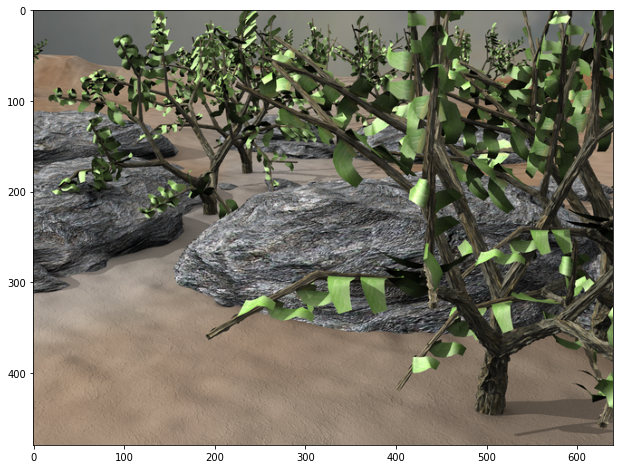

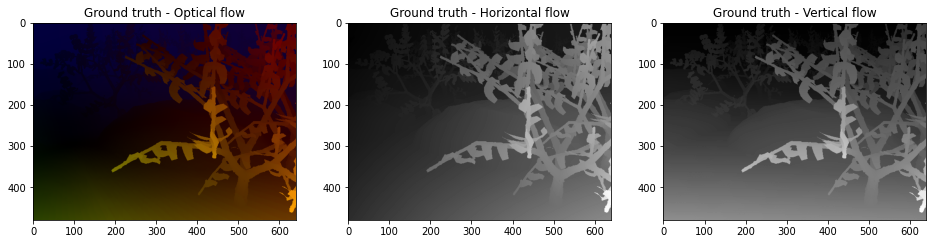


3 levels, window size = 5
Average End Point Error =  39.58561071840186
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

5 levels, window size = 5
Average End Point Error =  179.04664605457413
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

2 levels, window size = 5
Average End Point Error =  11.245570104856629
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

2 levels, window size = 3
Average End Point Error =  9.77399096881815
------------------------------------------------------------------------------

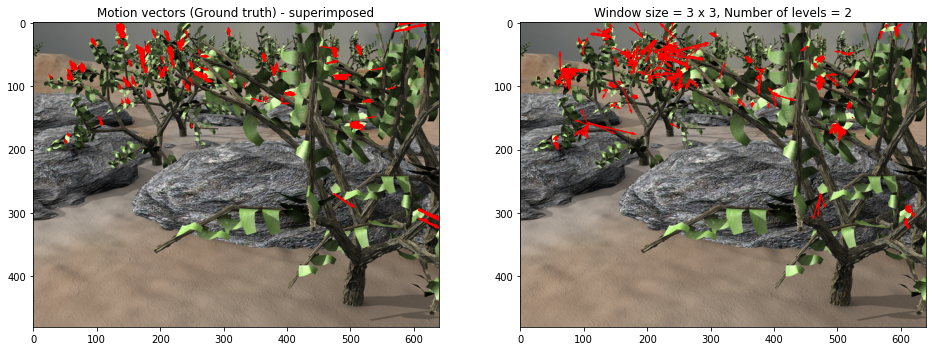

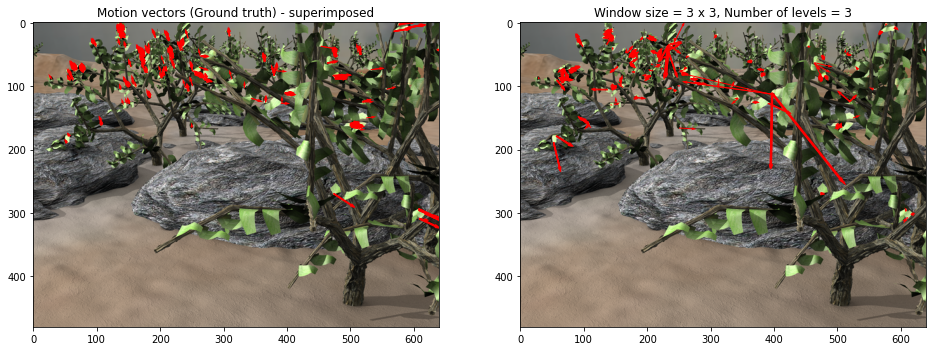

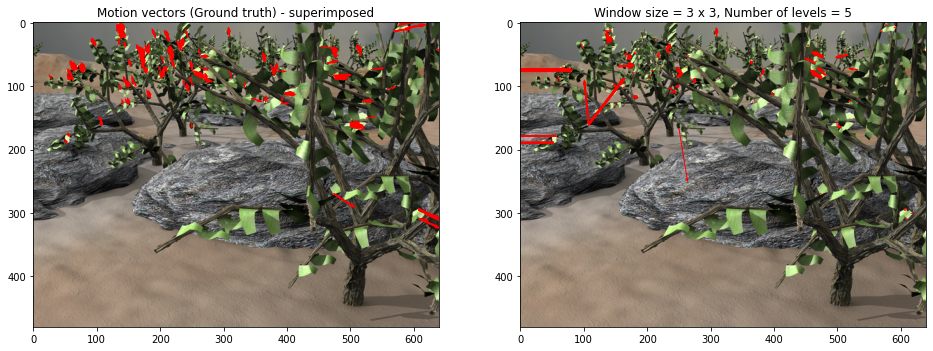

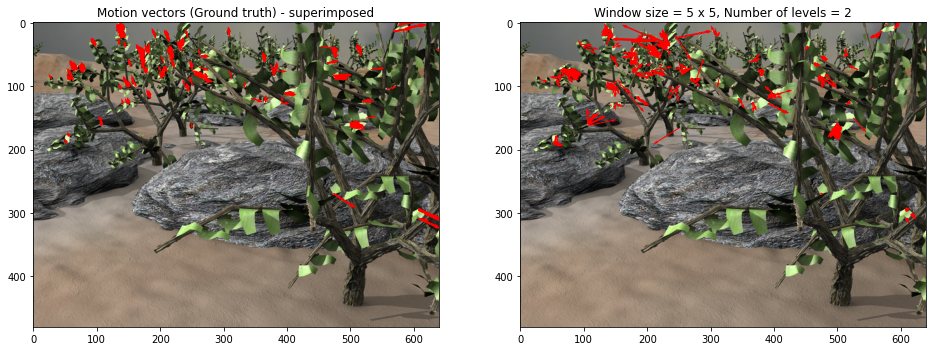

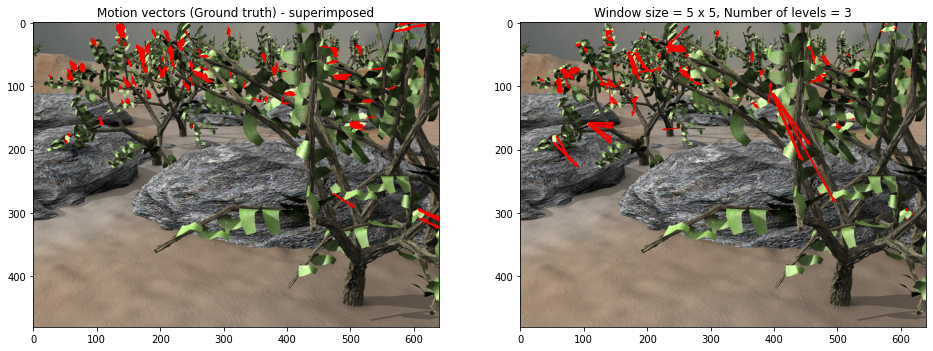

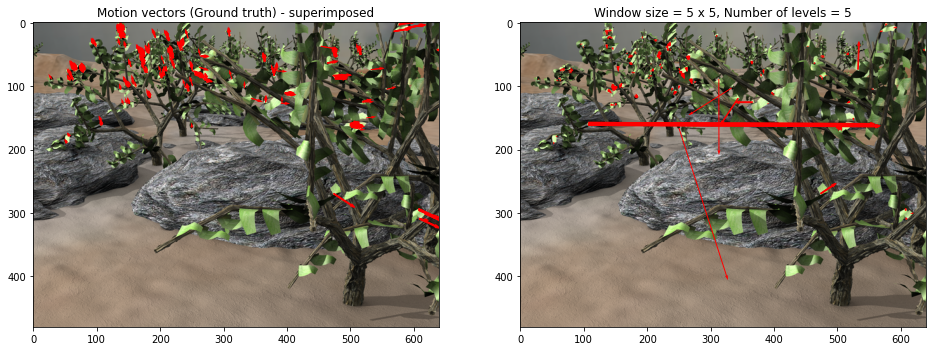

In [15]:
view_all_details(0)



RubberWhale




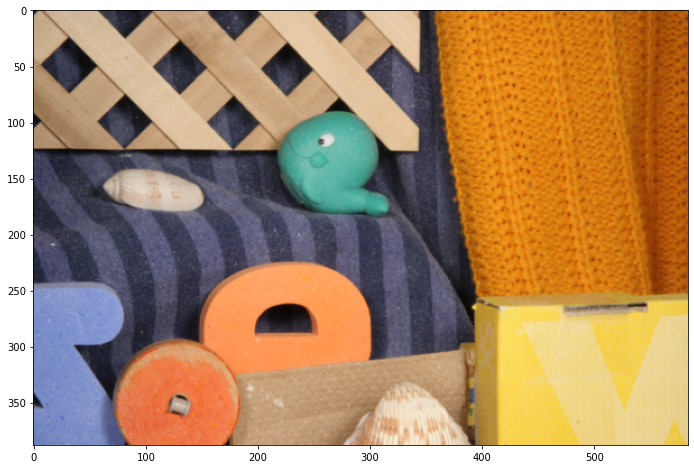

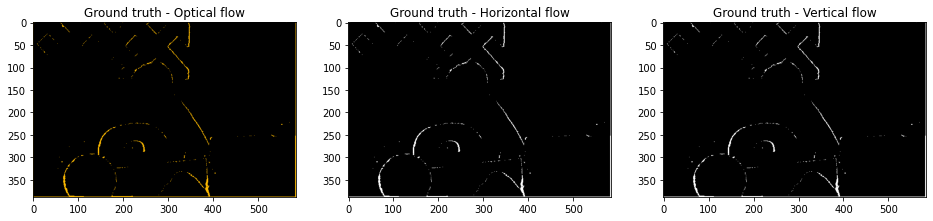


3 levels, window size = 5
Average End Point Error =  195538473.12865868
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

5 levels, window size = 5
Average End Point Error =  195538281.9312806
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

2 levels, window size = 5
Average End Point Error =  195537892.97308832
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

2 levels, window size = 3
Average End Point Error =  146659252.55031845
----------------------------------------------------------------------------

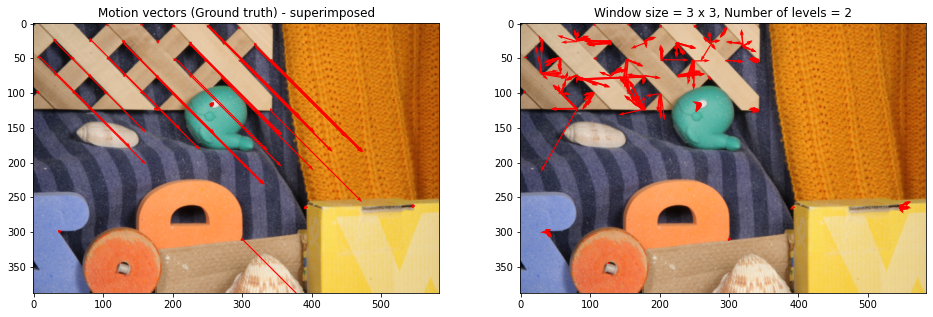

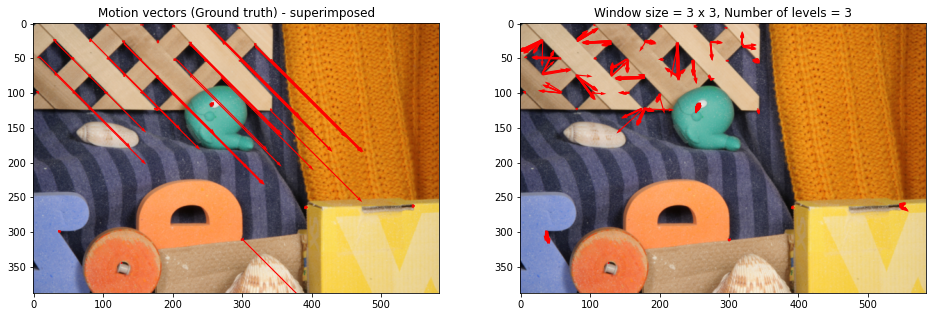

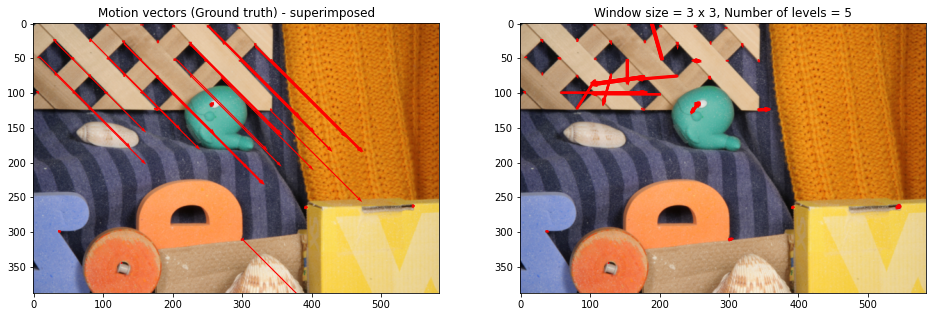

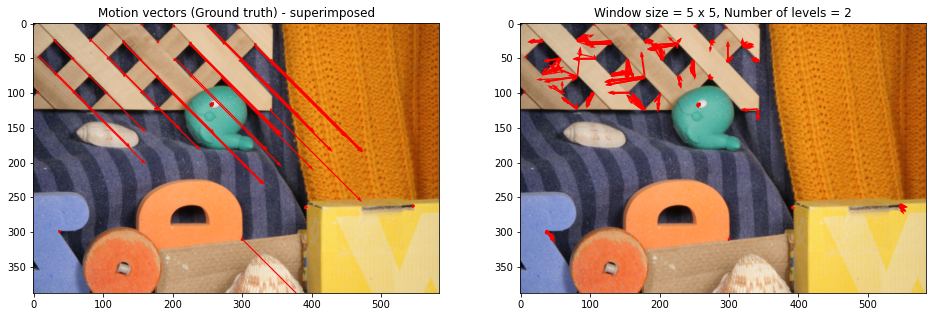

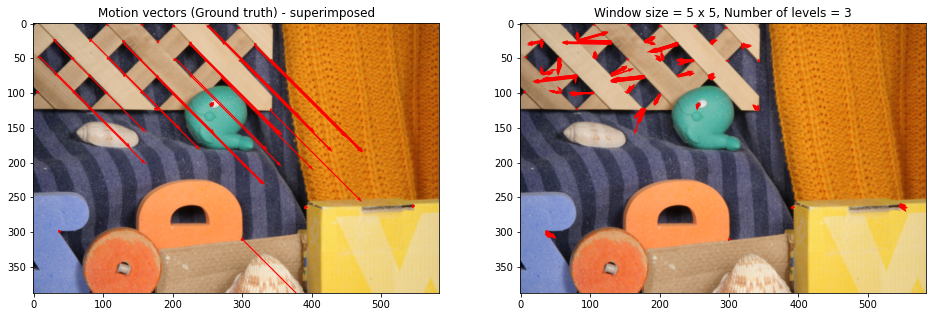

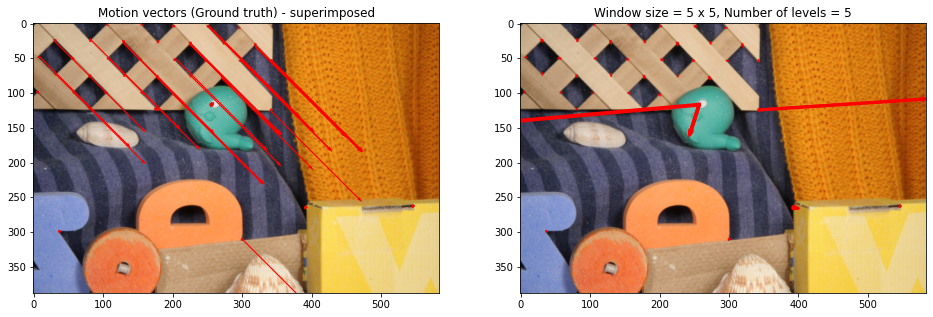

In [16]:
view_all_details(1)



Urban2




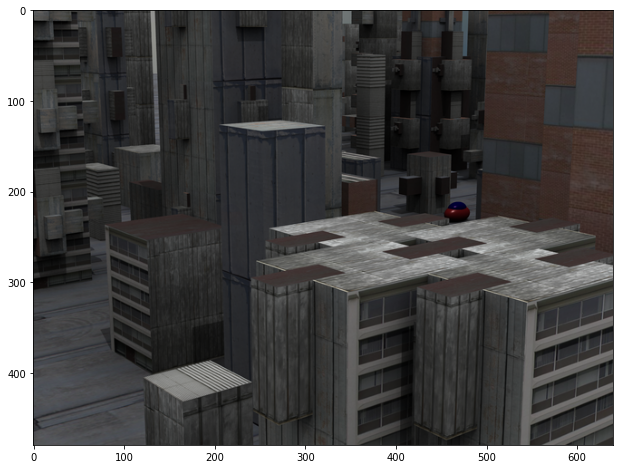

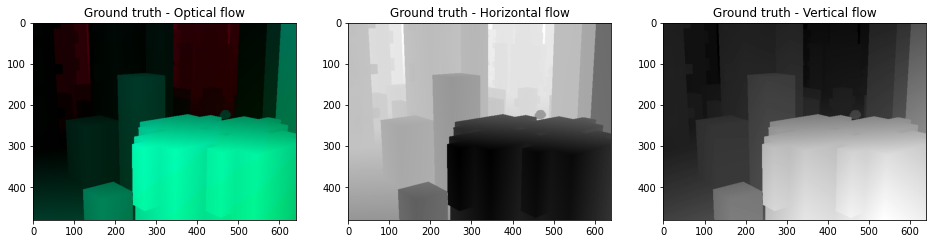


3 levels, window size = 5
Average End Point Error =  35.66534553329531
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

5 levels, window size = 5
Average End Point Error =  55.73747127192628
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

2 levels, window size = 5
Average End Point Error =  17.62313215992449
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

2 levels, window size = 3
Average End Point Error =  20.692053583414086
------------------------------------------------------------------------------

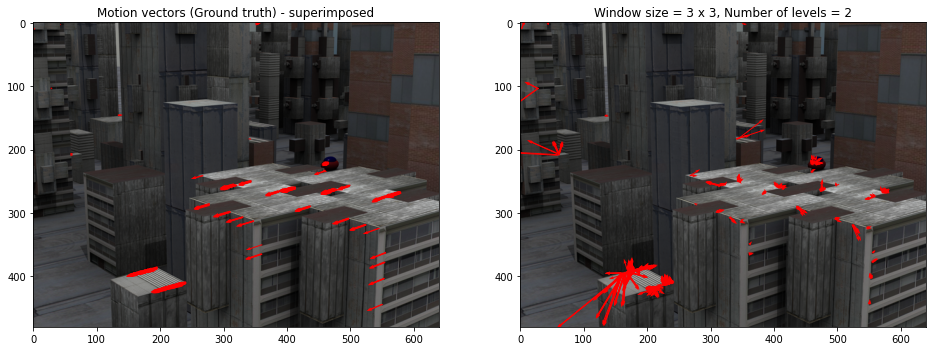

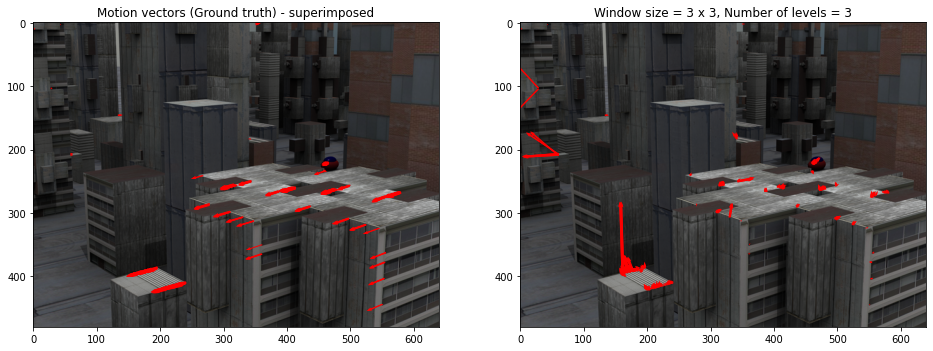

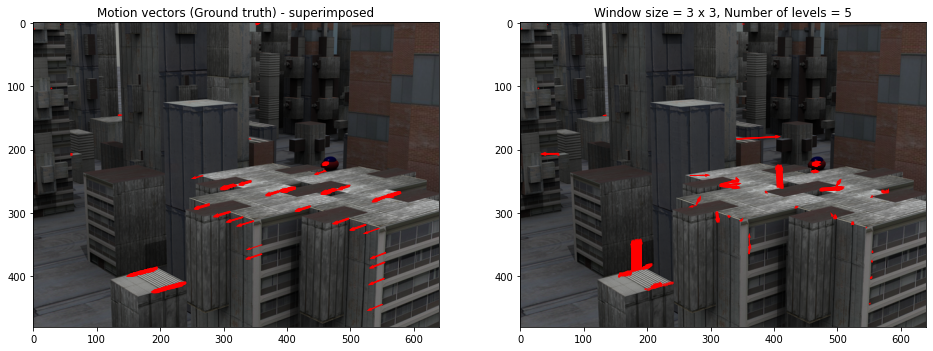

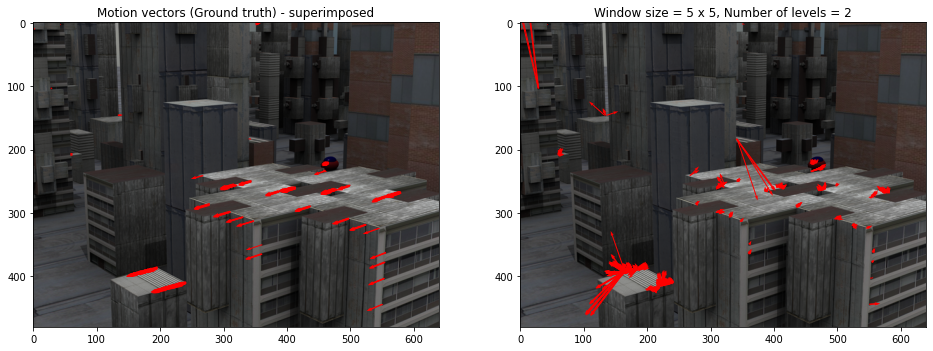

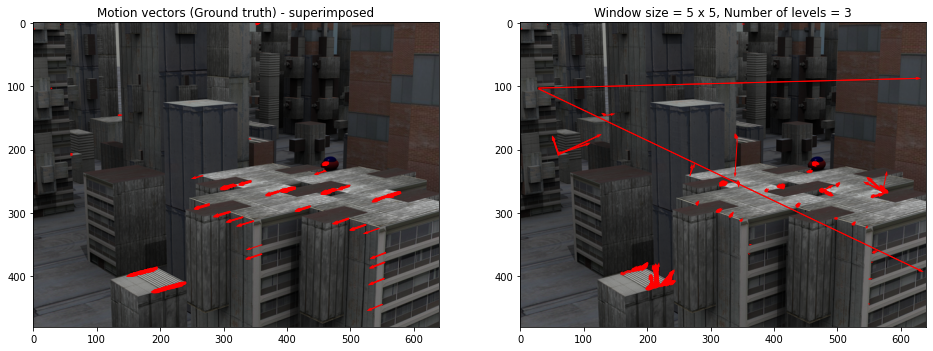

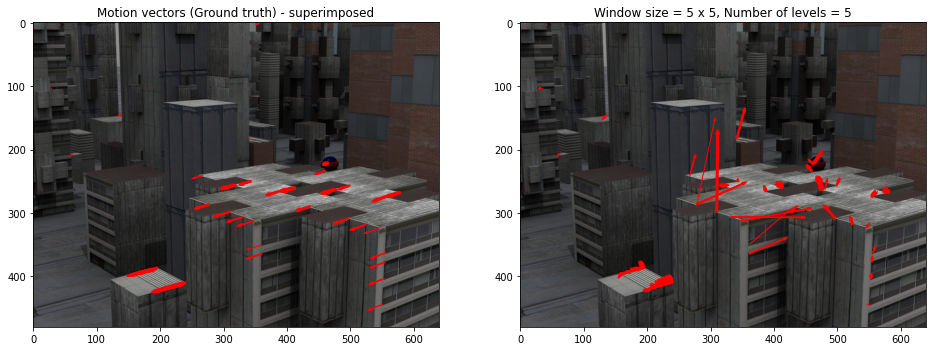

In [17]:
view_all_details(2)

**Analysis**

***Error Analysis***

It can be observed that the error value seems to increase with the number of levels, as higher number of levels indicate that there is excessive filtering happening creating a larger gaussian pyramid, which seems to have a negative effect while refining motion vector estimates (especially as the motion is typically small in most of given cases). 
It can also be observed that a smaller window size produced slightly lesser array, which highlights the fact that a relatively smaller window complements well the coarse-to-fine approach, in effectively computing motion vectors.

***Visualization***

We can observe that increasing the number of levels produces a rather erratic visualization with inaccurate motion depictions, including vectors with high magnitude. The output is more stable and meaningful in cases where number of levels isn't very huge, which eradicates the problem of error accumulation across levels in the Gaussian Pyramid.

***Number of Levels***

On increasing the number of levels, it was observed that the output produced was a less accurate depiction in comparison with having lesser levels (such as 2 and 3 levels yielded better output than 5 levels). This is due to the fact that the motion detected was relatively small, and adding more levels needlessly degraded the information of the image, and led to error accumulation.

***Window size***

In all the cases of Coarse-to-fine optical flow, it was found that a smaller window size worked better, as the construction of Gaussian Pyramid (blurring and sub-sampling) has led to more pixel information being captured in a smaller window, thereby exploiting the advantages of a system which is not over-constrained (as in the case of high window size). Thus, smaller window size (3) yielded better outputs than a relatively larger window size (5).

**Comparison with Lucas Kanade**

In majority of the cases (in given data), Lucas Kanade approach seemed to outperform the multi-scale approach, due to the fact that the motion is small and error propagates significantly. Although, we can observe that the Multi-Scale approach clearly outperformed Lucas Kanade for the RubberWhale image, where a window size of 3 was used (2 additional levels in pyramid of Coarse-to-Fine). This is a case where the motion was large, and hence serves as a classic example where Multi Scale Coarse-to-Fine approach performs better - when the motion is significant within the image. This approach seems to tackle the aperture problem, which cannot be solved by Lucas Kanade.

In [18]:
!zip -r Grove3.zip Grove3
!zip -r RubberWhale.zip RubberWhale
!zip -r Urban2.zip Urban2

  adding: Grove3/ (stored 0%)
  adding: Grove3/.ipynb_checkpoints/ (stored 0%)
  adding: Grove3/output/ (stored 0%)
  adding: Grove3/output/Grove3_3_2.png (deflated 2%)
  adding: Grove3/output/Grove3_3_3.png (deflated 2%)
  adding: Grove3/output/Grove3_5_5.png (deflated 2%)
  adding: Grove3/output/Grove3_3_5.png (deflated 2%)
  adding: Grove3/output/Grove3_5_2.png (deflated 2%)
  adding: Grove3/output/Grove3_5_3.png (deflated 1%)
  adding: Grove3/gt_flows.png (deflated 4%)
  adding: RubberWhale/ (stored 0%)
  adding: RubberWhale/.ipynb_checkpoints/ (stored 0%)
  adding: RubberWhale/output/ (stored 0%)
  adding: RubberWhale/output/RubberWhale_5_5.png (deflated 2%)
  adding: RubberWhale/output/RubberWhale_3_5.png (deflated 2%)
  adding: RubberWhale/output/RubberWhale_5_3.png (deflated 2%)
  adding: RubberWhale/output/RubberWhale_5_2.png (deflated 2%)
  adding: RubberWhale/output/RubberWhale_3_3.png (deflated 2%)
  adding: RubberWhale/output/RubberWhale_3_2.png (deflated 2%)
  adding: Rub

In [19]:
from google.colab import files
files.download("Grove3.zip")
files.download("RubberWhale.zip")
files.download("Urban2.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>